In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours


In [8]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

['div', 'mul', '9', '0', '7', '6', '1', '8', 'sub', 'add', '4', '3', '2', '5']
7600
7600
labels : ['8', '3', 'div', '6', '7', 'mul', '4', '5', '9', 'sub', 'add', '1', '0', '2']


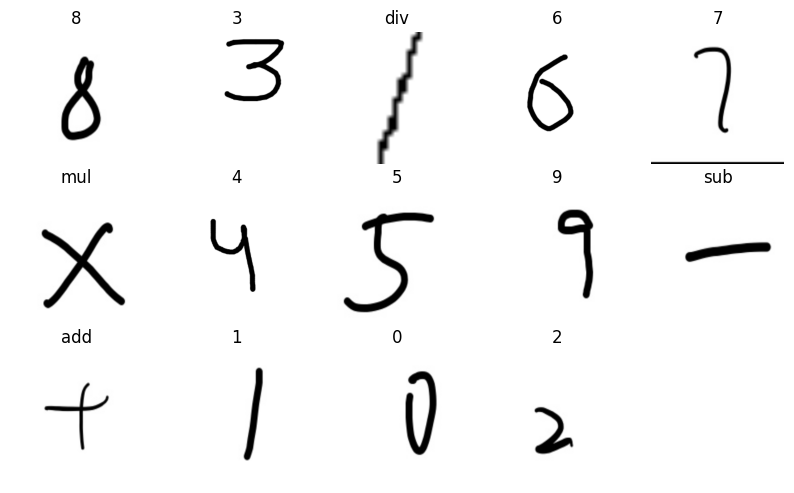

In [9]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

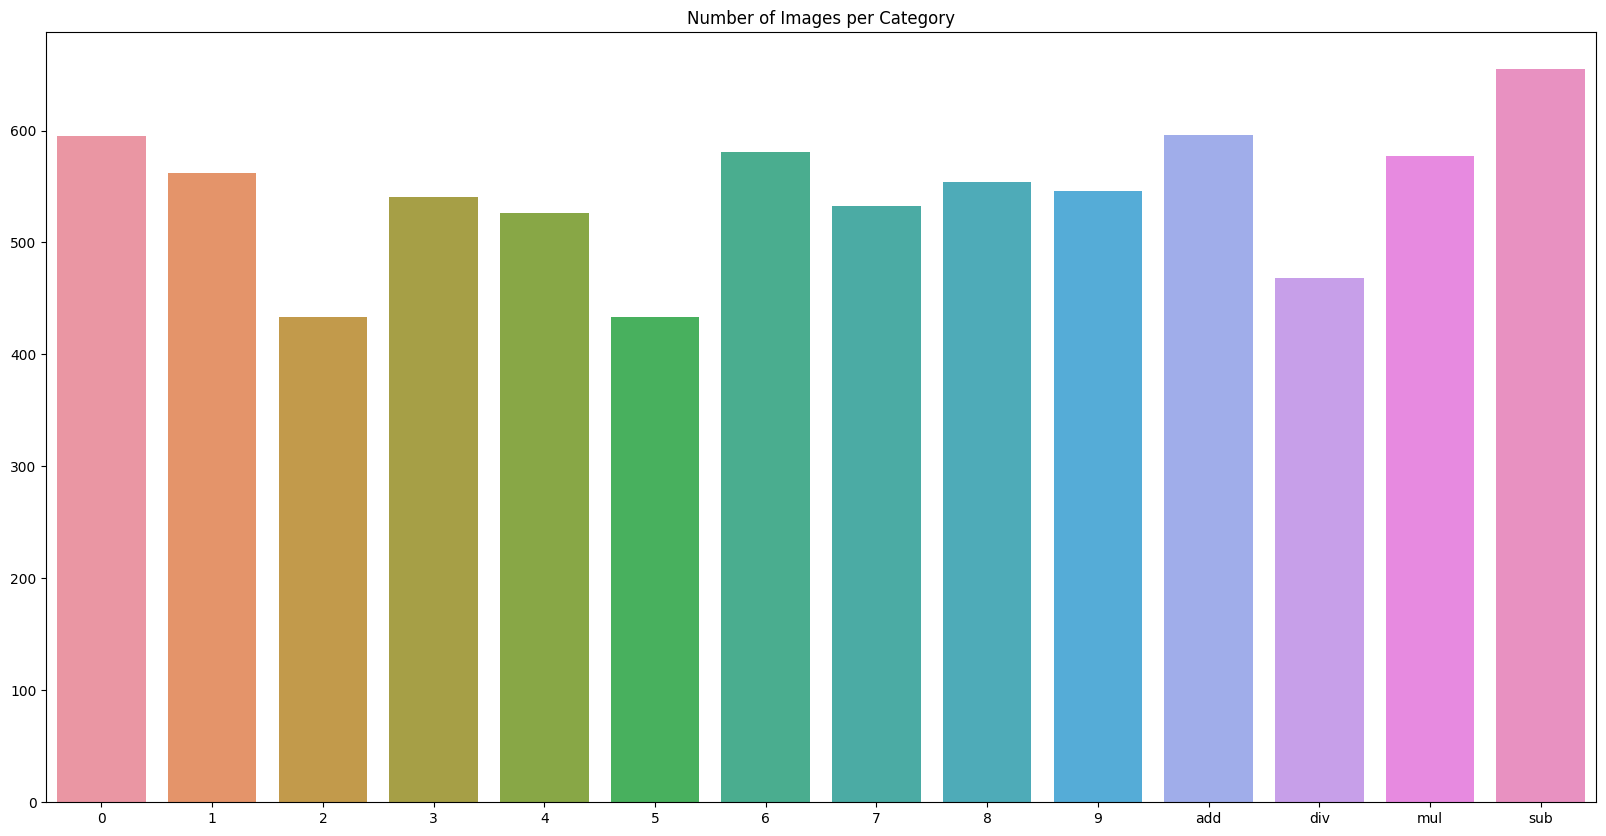

In [16]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [17]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [18]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)


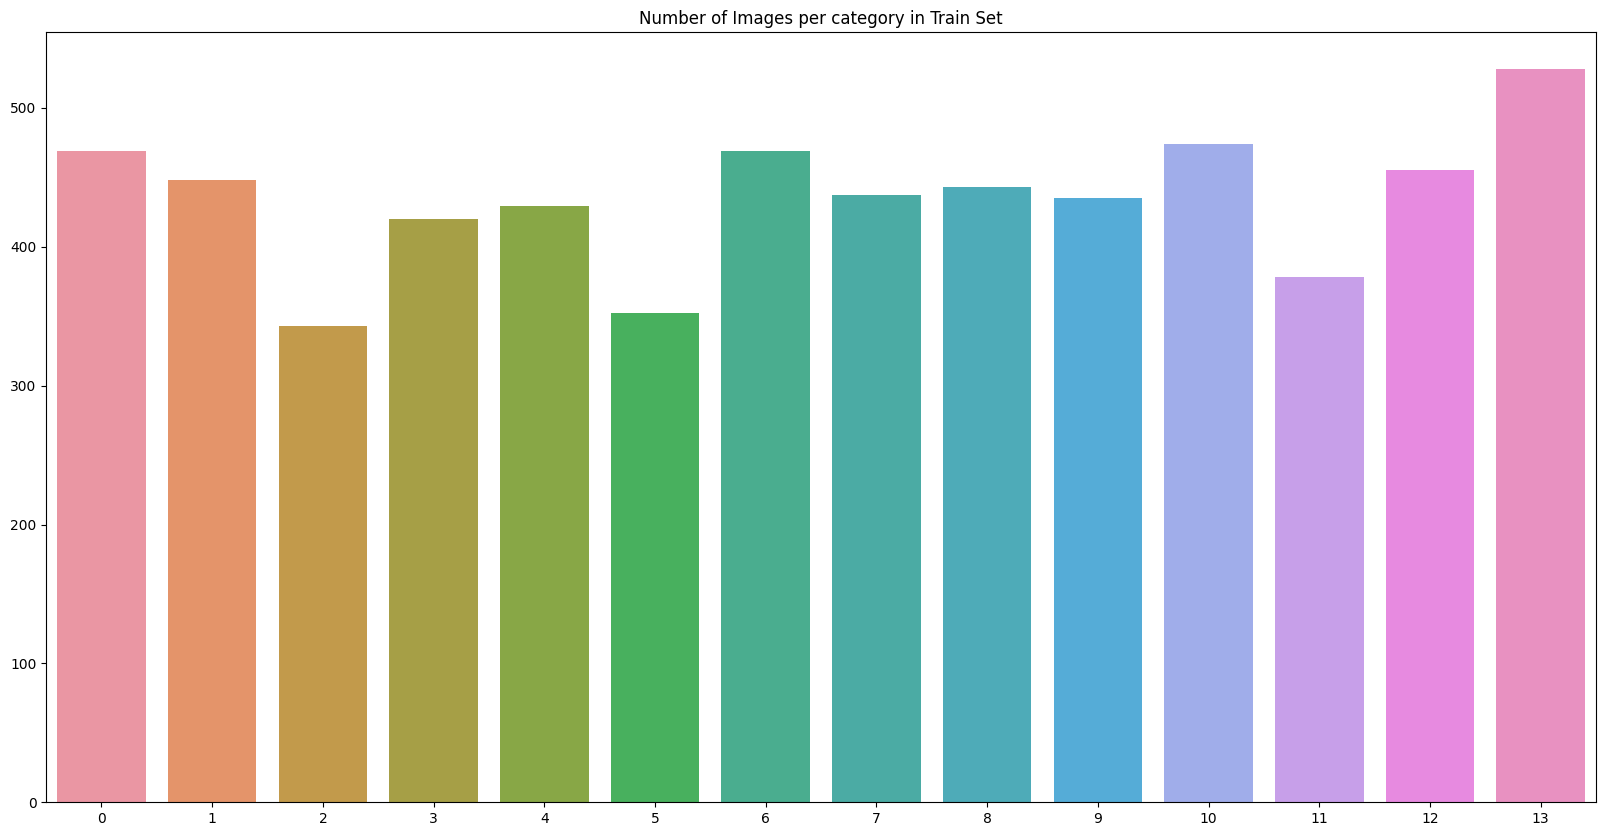

In [21]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

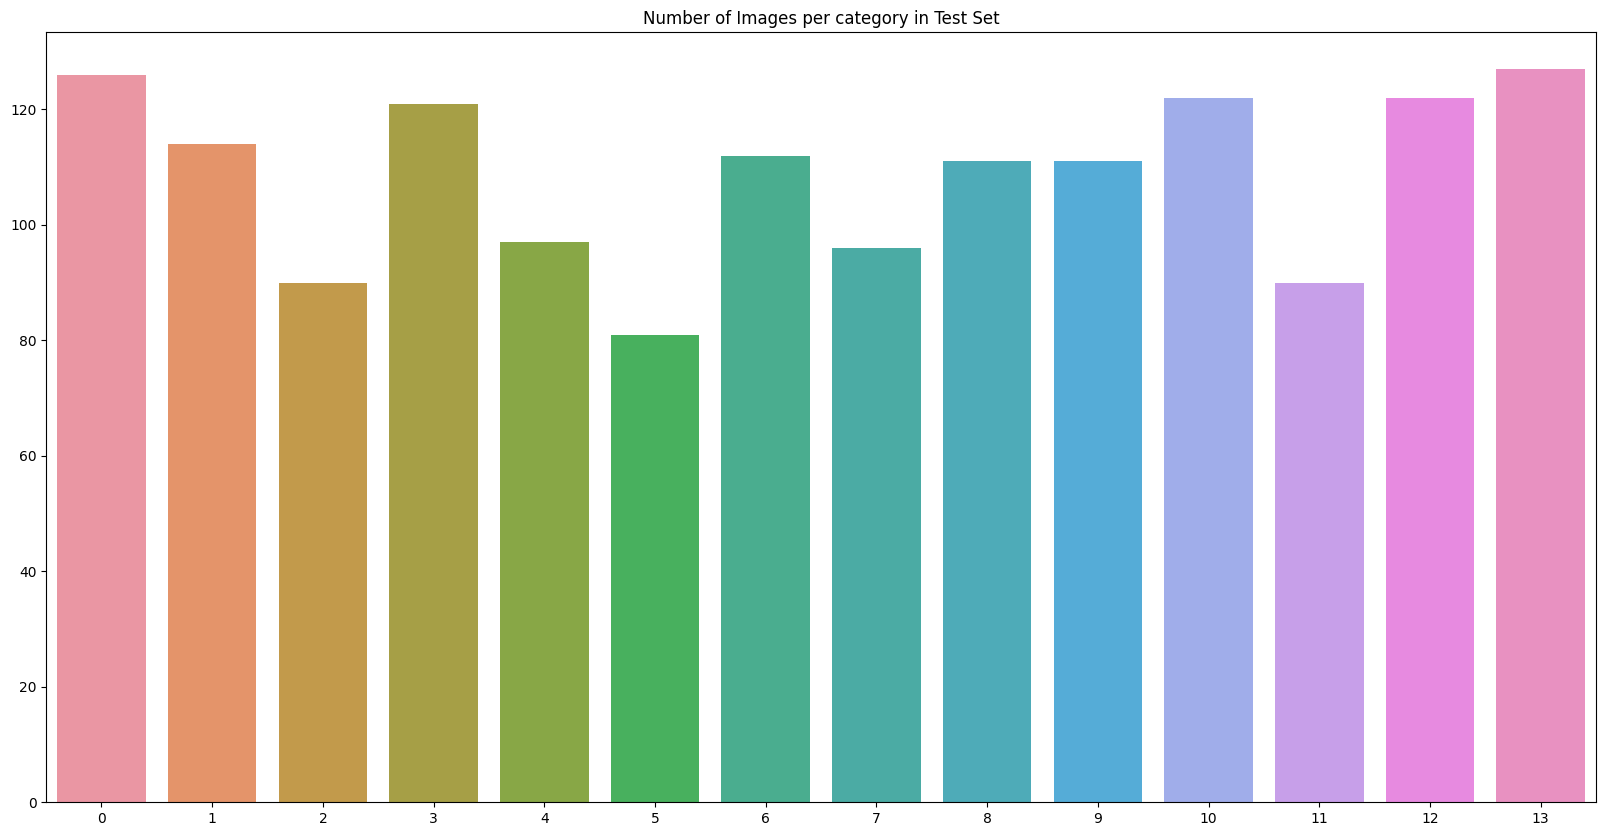

In [22]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

In [23]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [24]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [25]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

2022-11-29 14:11:30.714049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-29 14:11:30.715034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)

In [26]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [27]:
aug = ImageDataGenerator(zoom_range=0.1,
                         rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100


2022-11-29 14:12:05.355897: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-29 14:12:05.833918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 2.7668 - accuracy: 0.2396

2022-11-29 14:12:11.406586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 6s 46ms/step - loss: 2.7668 - accuracy: 0.2396 - val_loss: 2.1960 - val_accuracy: 0.4750
Epoch 2/100
48/48 [==============================] - 2s 34ms/step - loss: 1.7189 - accuracy: 0.5669 - val_loss: 1.4388 - val_accuracy: 0.7105
Epoch 3/100
48/48 [==============================] - 2s 34ms/step - loss: 1.1971 - accuracy: 0.7000 - val_loss: 1.1687 - val_accuracy: 0.7322
Epoch 4/100
48/48 [==============================] - 2s 33ms/step - loss: 0.9400 - accuracy: 0.7780 - val_loss: 0.9017 - val_accuracy: 0.8250
Epoch 5/100
48/48 [==============================] - 2s 31ms/step - loss: 0.8247 - accuracy: 0.8058 - val_loss: 1.0352 - val_accuracy: 0.7553
Epoch 6/100
48/48 [==============================] - 2s 33ms/step - loss: 0.7269 - accuracy: 0.8342 - val_loss: 1.0557 - val_accuracy: 0.7408
Epoch 7/100
48/48 [==============================] - 2s 32ms/step - loss: 0.6592 - accuracy: 0.8531 - val_loss: 0.8790 - val_accuracy: 0.8026
Epoch 8/100
48/48 

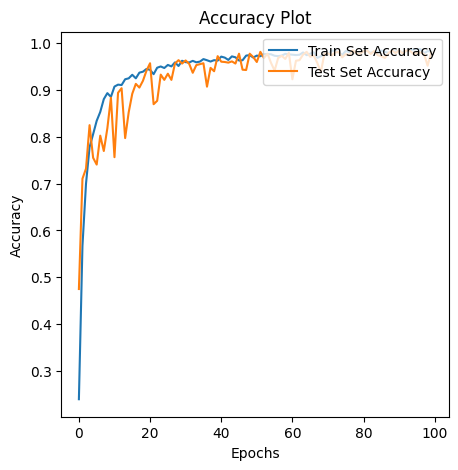

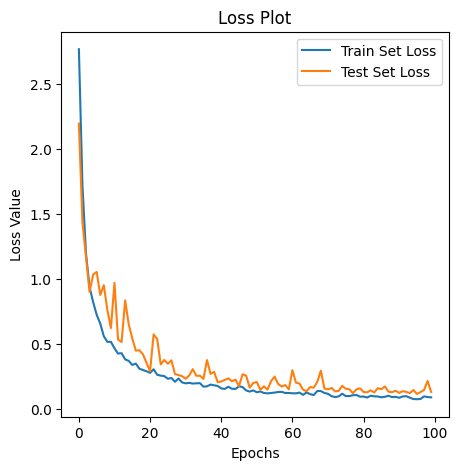

In [31]:
figure = plt.figure(figsize=(5, 5))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [32]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       126
           1       0.99      0.96      0.98       114
           2       1.00      1.00      1.00        90
           3       0.98      0.99      0.99       121
           4       0.95      0.95      0.95        97
           5       1.00      0.94      0.97        81
           6       0.96      0.97      0.96       112
           7       0.99      1.00      0.99        96
           8       0.94      0.98      0.96       111
           9       0.94      0.99      0.96       111
          10       1.00      0.99      1.00       122
          11       1.00      1.00      1.00        90
          12       0.99      1.00      1.00       122
          13       1.00      1.00      1.00       127

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.98    

In [30]:
model.save('digit_model.h5')